In [1]:
import sys

In [2]:
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install gym==0.25.1
!{sys.executable} -m pip install gym[toy_text]==0.25.1

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [64]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython import display
import time
import math
import random

from timeit import default_timer as timer
%matplotlib inline

In [4]:
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode="rgb_array")

max_episodes = 10000
max_steps = 200
learning_rate = 0.4
discount = 0.9


act_space = env.action_space
obs_space = env.observation_space



In [5]:
def calcPolicy(q_table):
  policy = np.empty((4,4))
  index = 0
  for row in q_table:
    if np.sum(row) == 0:
      policy[int(index/4),int(index%4) ] = float('nan')
    else:
      policy[int(index/4),int(index%4) ] = np.argmax(row)
    index += 1
  return policy

In [96]:
def runEpisode(env, q_table, learning_rate, discount, exploration_rate, max_steps=200):
    state = env.reset()
    episode_score = 0
    for step in range(max_steps):

        ## Decide an action
        
        exploration_rate_threshold = random.uniform(0, 1)
        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[state,:])
        else:
            action = env.action_space.sample()

        new_state, reward, terminated = env.step(action)
        
        episode_score += reward
        
        # current_q_value = q_table[state, action]
        
        # optimal_future_value = np.max(q_table[new_state])
        
        # q_table[state,action] = current_q_value + learning_rate * (reward + discount * optimal_future_value - current_q_value) 
        q_table[state, action] = q_table[state, action] * (1 - learning_rate) + \
            learning_rate * (reward + discount * np.max(q_table[new_state, :]))
            
        state = new_state

        if terminated:

            break
    return q_table,episode_score



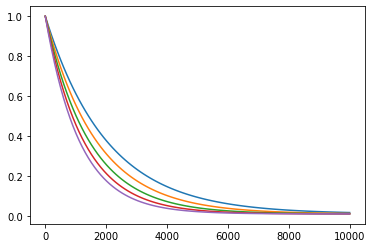

In [97]:
def explorationDecayRate(episodes,max,min,factor):
  decay_rate = (max-min)/episodes
  x = np.linspace(0,episodes,num=100)
  y = min+(max-min)*np.exp(-decay_rate*factor*x)
  plt.plot(x,y)

for i in range(5,10):
  explorationDecayRate(10000,1,0.01,i)

In [94]:

def trainModel(env,episodes, learning_rate, discount_factor, exploration_factor_max, exploration_factor_min, exploration_factor_decay):
  start = timer()
  q_table = np.zeros([obs_space.n, act_space.n])
  all_scores = []
  exploration_factor = exploration_factor_max
  exploration_decay_rate = (exploration_factor_max - exploration_factor_min) / episodes
  end = timer()
  print(end-start)
  times = []
  for episode in range(episodes):
      start = timer()
      q_table, episode_score = runEpisode(env, q_table, 0.4, 0.9, 0.5)
      end = timer()
      times.append(end-start)
      
      all_scores.append(episode_score)
      
      exploration_factor = (exploration_factor_max - exploration_factor_min)*np.exp(-exploration_decay_rate*exploration_factor_decay*episode)
     
  
  print(np.mean(times))
  score_per_thousand = np.split(np.array(all_scores), episodes/1000)
  return q_table, score_per_thousand


In [98]:
q_table, score_per_thousand = trainModel(env,1000, 0.4, 0.9, 1,0.01, 5)


6.788999598938972e-06


ValueError: too many values to unpack (expected 3)

In [67]:

index = 1
for bin in score_per_thousand:
    print("{0}: {1}".format(index*1000, np.sum(bin)/1000))
    index += 1


1000: 0.365


In [581]:

print(calcPolicy(q_table))
print(q_table)



[[ 1.  2.  1.  0.]
 [ 1. nan  1. nan]
 [ 2.  1.  1. nan]
 [nan  2.  2. nan]]
[[0.531441 0.59049  0.59049  0.531441]
 [0.531441 0.       0.6561   0.59049 ]
 [0.59049  0.729    0.59049  0.6561  ]
 [0.6561   0.       0.59049  0.59049 ]
 [0.59049  0.6561   0.       0.531441]
 [0.       0.       0.       0.      ]
 [0.       0.81     0.       0.6561  ]
 [0.       0.       0.       0.      ]
 [0.6561   0.       0.729    0.59049 ]
 [0.6561   0.81     0.81     0.      ]
 [0.729    0.9      0.       0.729   ]
 [0.       0.       0.       0.      ]
 [0.       0.       0.       0.      ]
 [0.       0.81     0.9      0.729   ]
 [0.81     0.9      1.       0.81    ]
 [0.       0.       0.       0.      ]]


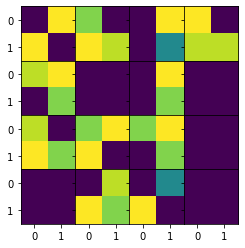

In [574]:


fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0,  # pad between axes in inch.
                 )

for ax, im in zip(grid, q_table.reshape(16,2,2)[:,:,0:]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()